# Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


# Import Libraries

In [ ]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [ ]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import shutil
import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

seed = 42

## Help Functions

In [ ]:
def plot_images(images, num=9):
    plt.figure(figsize=(8, 8))
    for i in range(num):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()



# Load the Data

In [ ]:
#Load the dataset from the .npz file and take "images" and "labels"
data = np.load('training_set_without_outlier.npz')
images = data['images']
labels = data['labels']

#Initial shuffle of the data
indices = np.random.permutation(len(images))
shuffled_images = images[indices]
shuffled_labels = labels[indices]

#Free some memory
del data
del images
del labels
del indices

# Process Data

In [ ]:
#Normalization of images and categorical format for labels
normalized_images = shuffled_images / 255.0
categorical_labels = to_categorical(shuffled_labels).astype('float32')


In [ ]:
# Split data into Training set and Validation set
X_train, X_val, y_train, y_val = train_test_split(normalized_images, categorical_labels, test_size=0.2, stratify=categorical_labels)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training set shape: (9567, 96, 96, 3)
Validation set shape: (2392, 96, 96, 3)
Training labels shape: (9567, 8)
Validation labels shape: (2392, 8)


# Augmentation

Prime 9 immagini originali:


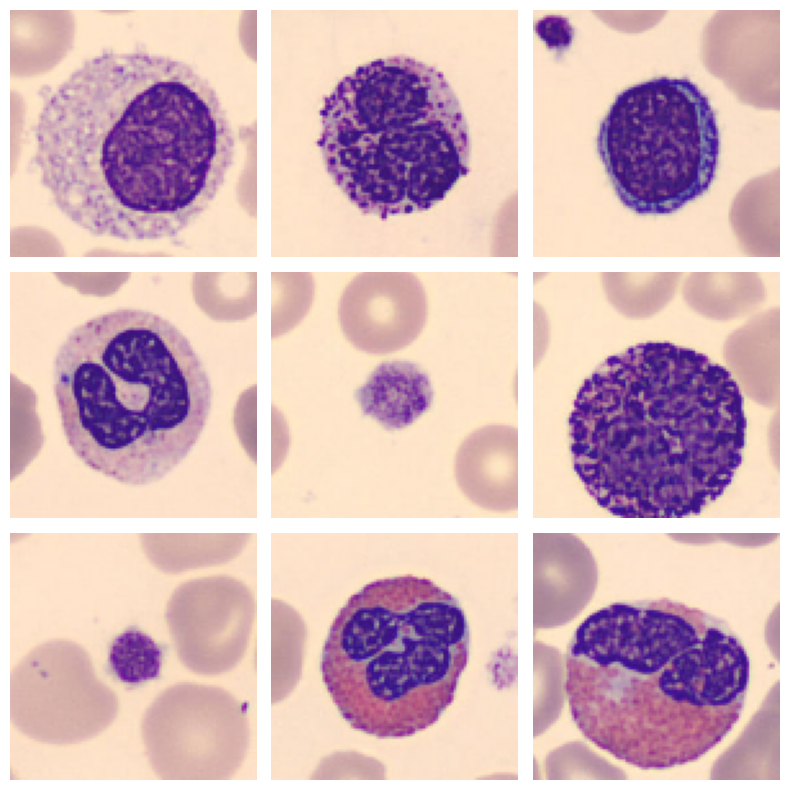

In [ ]:
#First we plot the first 9 images of the dataset, to have a look at them
plot_images(normalized_images, num=9)

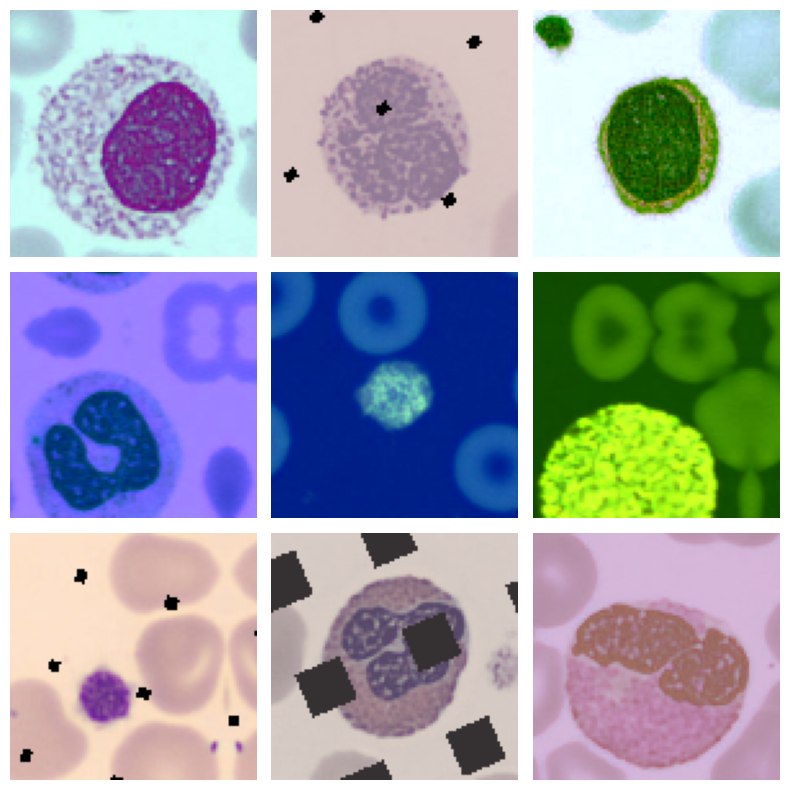

In [ ]:
#Through Keras_cv we define a random pipeline of augmentations
data_augmentation = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.ChannelShuffle(groups=3, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed),
        keras_cv.layers.Solarization(value_range = (0.0, 1.0), seed=seed),
        keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.4), rotation_factor=0.2, fill_mode="constant", fill_value=0.0, seed=seed)
    ],
    seed=seed,
    augmentations_per_image=3
)


# Test the augmentation just on the first 9 images
augmented_images = data_augmentation(normalized_images[:9])

#The augmentation layer transforms the input into a tensor, here we just convert it into numpy
augmented_images = augmented_images.numpy()

#Plot augmented images
plot_images(augmented_images, num=9)

In [ ]:
X_train = data_augmentation(X_train)
X_val = data_augmentation(X_val)

In [ ]:
# Convert the Training set and Validation set into an appropriate format for the CutMix and Mixup transformations.
# Indeed the images and labels need to be coupled for such transformation
batch_size = 32  # Adjust as needed
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Define the CutMix and Mixup augmentations
cutmix = keras_cv.layers.CutMix(seed=seed)
mixup = keras_cv.layers.MixUp(seed=seed)

# Define a function to apply CutMix or MixUp (manually modified)
def apply_advanced_augmentation(images, labels):
    return cutmix({"images": images, "labels": labels})

# Apply advanced augmentation to the train dataset
train_dataset = train_dataset.map(lambda x, y: apply_advanced_augmentation(x, y))
val_dataset = val_dataset.map(lambda x, y: apply_advanced_augmentation(x, y))

In [ ]:
# Reconvert the Training and Validation set into numpy arrays
X_train, y_train = [], []
for batch in train_dataset:
    images = batch["images"].numpy()
    labels = batch["labels"].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

X_val, y_val = [], []
for batch in val_dataset:
    images = batch["images"].numpy()
    labels = batch["labels"].numpy()
    X_val.append(images)
    y_val.append(labels)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

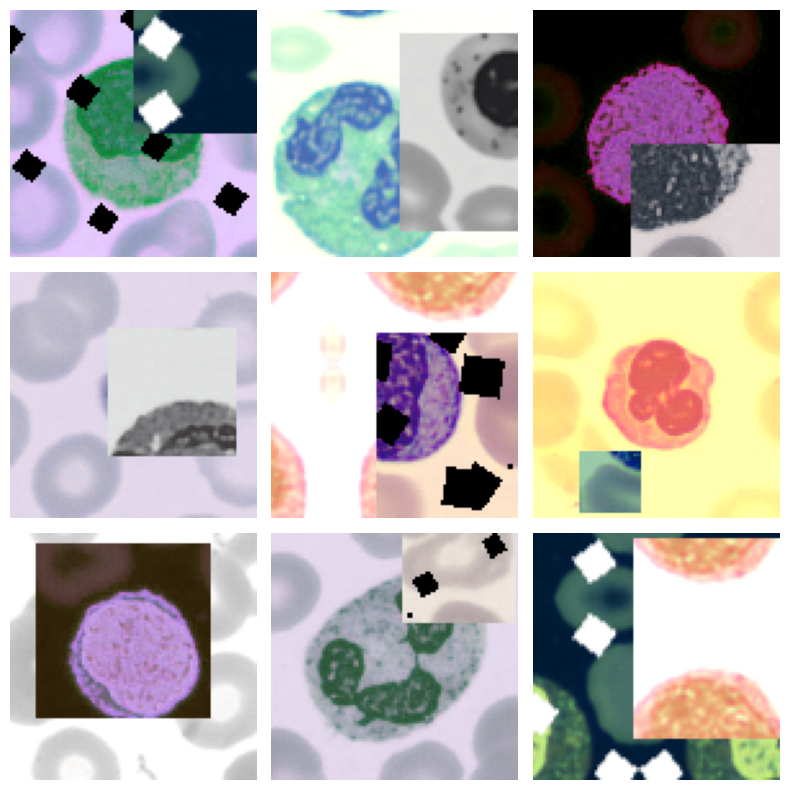

In [ ]:
#Additional plot of final result of images
plot_images(X_train, num=9)

# Define Models

In [ ]:
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.001
batch_size = 64
epochs = 300

def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    name = "Simple_CNN"
):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    if name == "Simple_CNN":
      """Builds a simple CNN composed by Conv2D, Activations, Pooling and Dense layers"""

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=2)(x)

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=2)(x)

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

      x = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.Activation('relu')(x)
      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

    elif name == "Normalized_Regularized_CNN":
      """Builds CNN similar to SimpleCNN which uses BarchNormalization and Dropout layers"""
      input_layer = tfkl.Input(shape=input_shape, name='Input')

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=2)(x)
      x = tfkl.Dropout(0.2)(x)

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.2)(x)

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.2)(x)

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.2)(x)

      x = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.5)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model


 ## Simple_CNN summary


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d (Conv2D)                     │ (None, 96, 96, 64)           │         1,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation (Activation)             │ (None, 96, 96, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d (MaxPooling2D)        │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ (None, 48, 48, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_1 (Activation)           │ (None, 48, 48, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_1 (MaxPooling2D)      │ (None, 24, 24, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_2 (Conv2D)                   │ (None, 24, 24, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_2 (Activation)           │ (None, 24, 24, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_2 (MaxPooling2D)      │ (None, 12, 12, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_3 (Conv2D)                   │ (None, 10, 10, 512)          │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_3 (Activation)           │ (None, 10, 10, 512)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_3 (MaxPooling2D)      │ (None, 5, 5, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 512)                  │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 128)                  │        65,664 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_4 (Activation)           │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Output (Dense)                      │ (None, 8)                    │         1,032 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 1,617,672 (6.17 MB)

 Trainable params: 1,617,672 (6.17 MB)

 Non-trainable params: 0 (0.00 B)

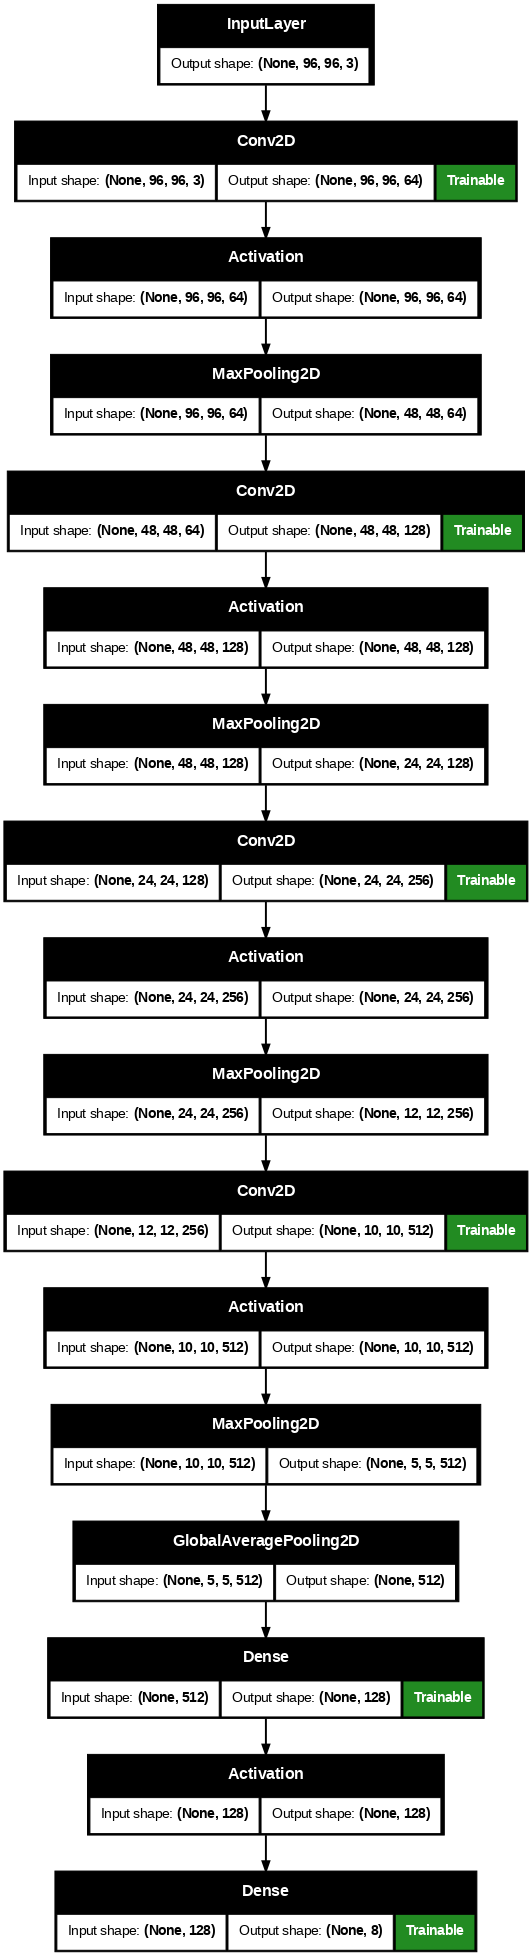

In [ ]:
# Build the model with specified input and output shapes
Simple_CNN = build_model(name = "Simple_CNN")

# Display a summary of the model architecture
Simple_CNN.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(Simple_CNN, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

 ## Normalized_Regularized_CNN summary


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_4 (Conv2D)                   │ (None, 96, 96, 64)           │         1,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 96, 96, 64)           │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_5 (Activation)           │ (None, 96, 96, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_4 (MaxPooling2D)      │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_5 (Conv2D)                   │ (None, 48, 48, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ (None, 48, 48, 128)          │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_6 (Activation)           │ (None, 48, 48, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_5 (MaxPooling2D)      │ (None, 24, 24, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 24, 24, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_6 (Conv2D)                   │ (None, 24, 24, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ (None, 24, 24, 256)          │         1,024 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_7 (Activation)           │ (None, 24, 24, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_6 (MaxPooling2D)      │ (None, 12, 12, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 12, 12, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_7 (Conv2D)                   │ (None, 10, 10, 512)          │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_3               │ (None, 10, 10, 512)          │         2,048 │    Y    │
│ (BatchNormalization) 

 Total params: 1,622,024 (6.19 MB)

 Trainable params: 1,619,848 (6.18 MB)

 Non-trainable params: 2,176 (8.50 KB)

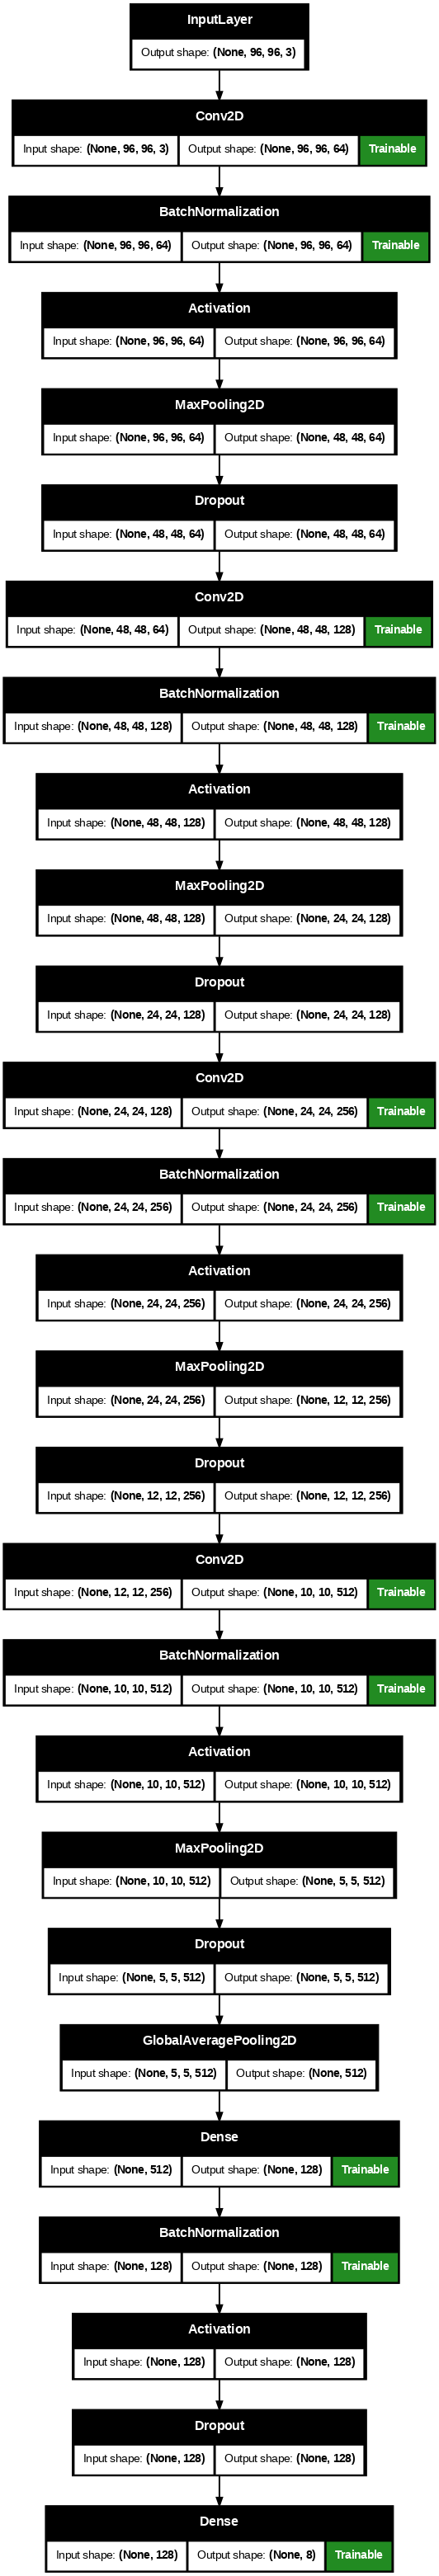

In [ ]:
# Build the model with specified input and output shapes
Normalized_Regularized_CNN = build_model(name = "Normalized_Regularized_CNN")

# Display a summary of the model architecture
Normalized_Regularized_CNN.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(Normalized_Regularized_CNN, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Early Stopping

In [ ]:
# Define the patience value for early stopping
patience = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# 🛠️ Train and Save Models


## Simple_CNN


In [ ]:
# Train the model with early stopping callback
history = Simple_CNN.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.1816 - loss: 2.2475 - val_accuracy: 0.2178 - val_loss: 1.9915
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.2139 - loss: 1.9826 - val_accuracy: 0.2094 - val_loss: 1.9727
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2341 - loss: 1.9541 - val_accuracy: 0.2412 - val_loss: 1.9337
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.2583 - loss: 1.9070 - val_accuracy: 0.2592 - val_loss: 1.8955
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.2930 - loss: 1.8576 - val_accuracy: 0.2801 - val_loss: 1.8924
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.3462 - loss: 1.7845 - val_accuracy: 0.3491 - val_loss: 1.7854
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.4065 - loss: 1.6883 - val_accuracy: 0.3717 - val_loss: 1.7254
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.4497 - loss: 1.61

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 44.9%


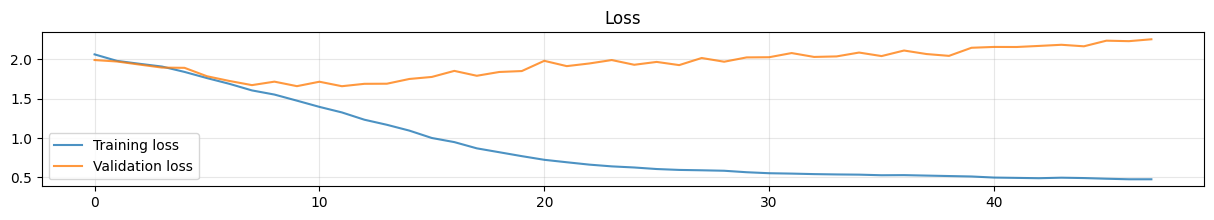

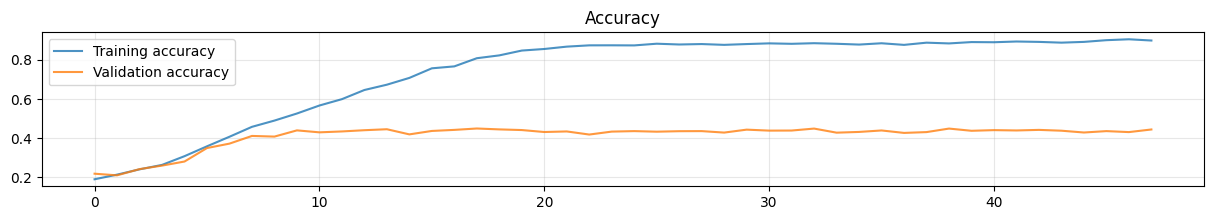

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


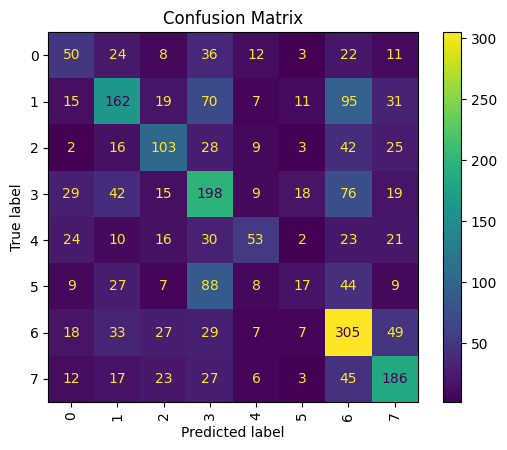

In [ ]:
#Print confusion matrix on the validation set
plot_confusion_matrix(Simple_CNN, X_val, y_val)

In [ ]:
Simple_CNN.save('Simple_CNN.keras')
del Simple_CNN

## Normalized_Regularized_CNN


In [ ]:
# Train the model with early stopping callback
history = Normalized_Regularized_CNN.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - accuracy: 0.1665 - loss: 2.4755 - val_accuracy: 0.1915 - val_loss: 2.0414
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.2077 - loss: 2.1225 - val_accuracy: 0.2145 - val_loss: 2.0307
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.2485 - loss: 1.9947 - val_accuracy: 0.2028 - val_loss: 2.0454
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.2744 - loss: 1.9281 - val_accuracy: 0.2003 - val_loss: 1.9954
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.3231 - loss: 1.8470 - val_accuracy: 0.2437 - val_loss: 1.9680
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.3347 - loss: 1.8073 - val_accuracy: 0.2554 - val_loss: 1.9321
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.3707 - loss: 1.7627 - val_accuracy: 0.2538 - val_loss: 1.9877
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.3850 - loss: 1.7

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 52.17%


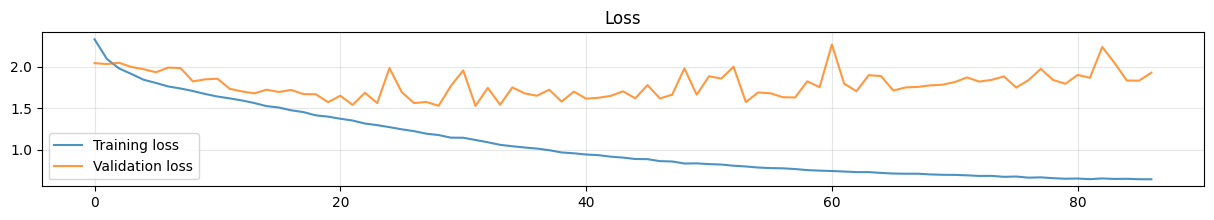

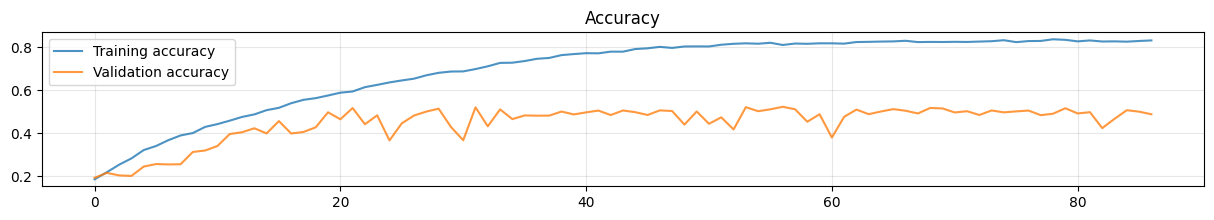

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


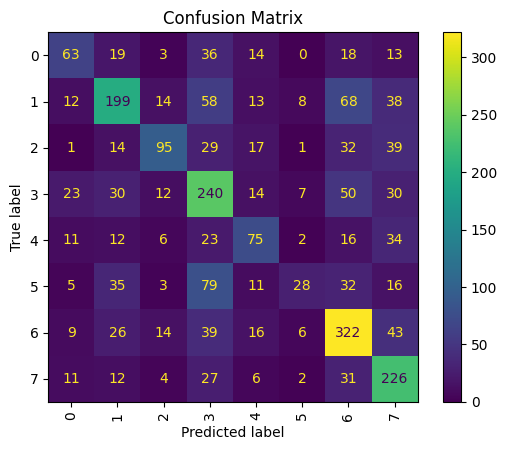

In [ ]:
#Print confusion matrix on the validation set
plot_confusion_matrix(Normalized_Regularized_CNN, X_val, y_val)

In [ ]:
Normalized_Regularized_CNN.save('Normalized_Regularized_CNN.keras')
del Normalized_Regularized_CNN

# 📊 Prepare Your Submission


In [ ]:
#source = "Simple_CNN.keras"
source = "Normalized_Regularized_CNN.keras"
destination = "weights.keras"

# Take a source an call it "weights.keras"
shutil.copy(source, destination)

'weights.keras'

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Load the model from the weights.keras file.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,).

        We check and normalize the image in X, extracting the prediction that the model does.
        """
        # Normalizzare le immagini (applicare la divisione per 255)
        if X.max() > 1.0:  # If max value is greater than 1, assume the range is [0, 255]
            X = X / 255.0

        # Fare la previsione con il modello
        preds = self.neural_network.predict(X)

        # Se l'output è in formato one-hot (shape = 2D), prendere l'argmax per ottenere le classi
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 52%)
  adding: weights.keras (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>